In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
customers = pd.read_csv('/content/drive/MyDrive/eCommerce Transactions Dataset/Customers.csv')
products =  pd.read_csv('/content/drive/MyDrive/eCommerce Transactions Dataset/Products.csv')
transactions = pd.read_csv('/content/drive/MyDrive/eCommerce Transactions Dataset/Transactions.csv')

In [ ]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
df = pd.merge(transactions, customers, on='CustomerID', how='inner')
df = pd.merge(df,products , on='ProductID', how='inner')
df = df.drop('Price_x',axis = 1)
df.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,CustomerName,Region,SignupDate,ProductName,Category,Price_y
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,Travis Campbell,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,Timothy Perez,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics,300.68


# RFM Analysis for Customer

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
recency_df = df.groupby(by='CustomerName', as_index=False)['TransactionDate'].max()
recency_df.columns = ['CustomerName', 'LastPurchaseDate']
recent_date = recency_df['LastPurchaseDate'].max()
recency_df['Recency'] = recency_df['LastPurchaseDate'].apply(lambda x: (recent_date - x).days)
frequency_df = df.groupby(by=['CustomerName'], as_index=False)['TransactionID'].count()
frequency_df.columns = ['CustomerName', 'Frequency']
monetary_df = df.groupby(by='CustomerName', as_index=False)['TotalValue'].sum()
monetary_df.columns = ['CustomerName', 'Monetary']
rf_df = recency_df.merge(frequency_df, on='CustomerName')
rfm_df = rf_df.merge(monetary_df, on='CustomerName').drop(columns='LastPurchaseDate')
rfm_df.head()

,CustomerName,Recency,Frequency,Monetary
0,Aaron Cox,41,4,1717.55
1,Abigail Jones,51,11,5487.25
2,Aimee Taylor,28,7,7572.91
3,Albert Burke,56,6,5316.46
4,Alexander Barker,0,6,3347.60


In [ ]:
# Normalize numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(rfm_df[['Frequency', 'Monetary', 'Recency']])

result_df = pd.DataFrame(scaled_features, columns=['Frequency', 'Monetary', 'Recency'])
result_df['CustomerName'] = rfm_df['CustomerName']

In [ ]:
# K Means Clustering - Methods for finding optimal clusters
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
inertia = []
sil_score = []
for n in range(2, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)
    sil_score.append(silhouette_score(scaled_features, kmeans.fit_predict(scaled_features)))

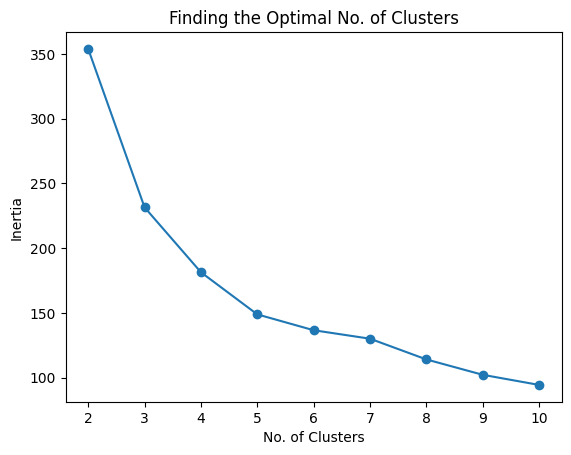

In [ ]:
# Elbow method to find the optimal number of clusters
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Finding the Optimal No. of Clusters')
plt.xlabel('No. of Clusters')
plt.ylabel('Inertia')
plt.show()

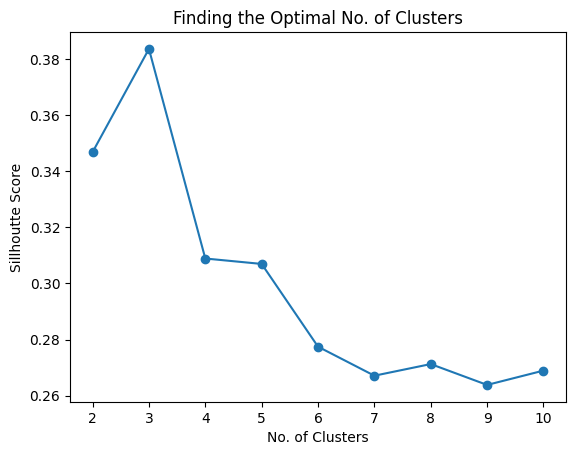

In [ ]:
# Elbow method to find the optimal number of clusters
plt.plot(range(2, 11), sil_score, marker='o')
plt.title('Finding the Optimal No. of Clusters')
plt.xlabel('No. of Clusters')
plt.ylabel('Sillhoutte Score')
plt.show()

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
# Perform hierarchical clustering
Z = linkage(scaled_features, method='ward')
result_df['Cluster_Hierarchical'] = fcluster(Z, t=3, criterion='maxclust')

# Clustering metric

In [ ]:
from sklearn.metrics import davies_bouldin_score
print(davies_bouldin_score(scaled_features,result_df['Cluster_Hierarchical']))

0.8767819373829943


# Cluster Visualization

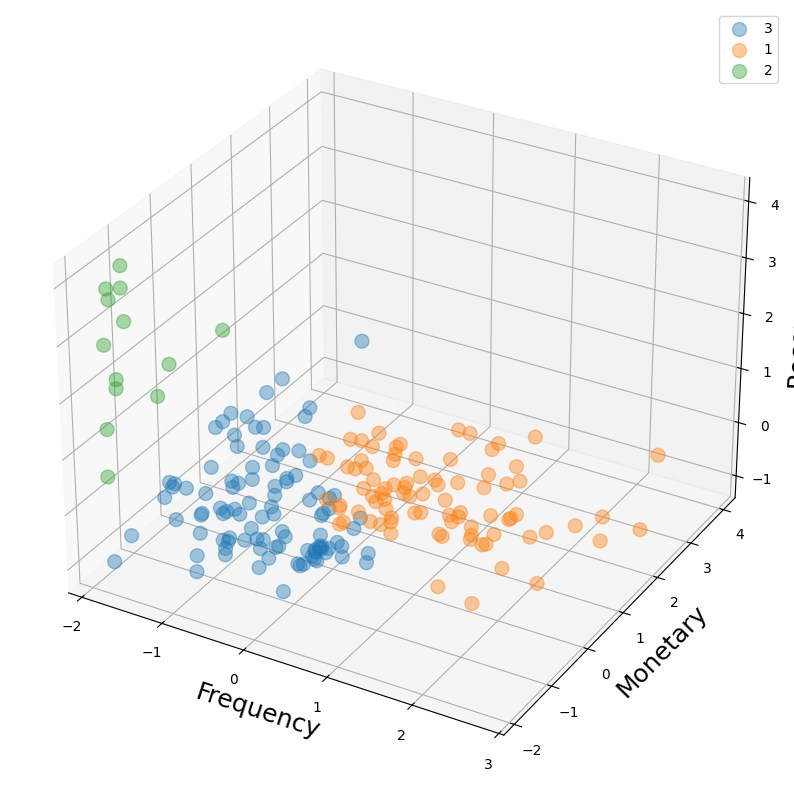

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 12))
ax = plt.axes(projection='3d')
for cluster in result_df['Cluster_Hierarchical'].unique() :
  result_cluster = result_df.loc[result_df['Cluster_Hierarchical'] == cluster]
  ax.scatter(result_cluster['Frequency'], result_cluster['Monetary'],  result_cluster['Recency'], label=cluster ,s=100, alpha=0.4)
ax.set_xlabel('Frequency', fontsize=18)
ax.set_ylabel('Monetary', fontsize=18)
ax.set_zlabel('Recency', fontsize=18)
ax.legend()
plt.show()